In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE

In [2]:
description = pd.read_csv('data/Variable_definitions.csv')
description

,Column Name,Definition
0,TransactionId,Уникальный идентификатор транзакции на платформе
1,BatchId,Уникальное идентификатор присваевыемый пакету ...
2,AccountId,Уникальный идентификатор пользователя на платф...
3,SubscriptionId,Уникальный идентификатор идентифицирующий подп...
4,CustomerId,Уникальный идентификатор привязанный к аккаунту
5,CurrencyCode,Валюта страны
6,CountryCode,Цифровой географический код страны
7,ProviderId,Поставщик товара
8,ProductId,Идентификатор купленного товара
9,ProductCategory,Категория товара


Загружаем размеченные данные:

In [3]:
train = pd.read_csv('data/train.csv')

Оценим сбалансированность классов:

Counter({0: 79750, 1: 140})

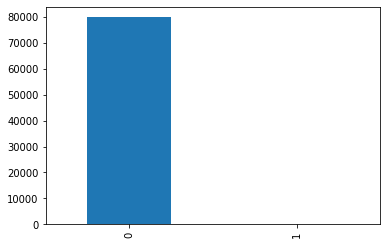

In [4]:
pd.value_counts(train['FraudResult']).plot.bar()
Counter(train['FraudResult'])

Наблюдается сильный дисбаланс классов, что в целом очевидно - количество мошеннических транзакций в реальном мире значительно меньше относительно легитимных

Оценим количество уникальных значений для каждого из признаков:

In [5]:
train.nunique()

TransactionId           79890
BatchId                 79132
AccountId                3219
SubscriptionId           3215
CustomerId               3311
CurrencyCode                1
CountryCode                 1
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Amount                   1429
Value                    1300
TransactionStartTime    78961
PricingStrategy             4
FraudResult                 2
ClientProfile               5
TrasactionCategory          3
dtype: int64

Колонки "CurrencyCode" и "CountryCode" имеют единственное значение для всех эксземпляров. Соответственно, в них отсутствует полезная информация и их можно удалить.

In [6]:
train.drop(columns=['CurrencyCode', 'CountryCode'], inplace=True)

Колонки "TransactionId" и "BatchId", наоборот, имеют слишком много уникальных значений и также не могут нести полезной информации в таком случае.

In [7]:
train.drop(columns=['TransactionId', 'BatchId'], inplace=True)

Провизуализируем остальные признаки относительно классов:

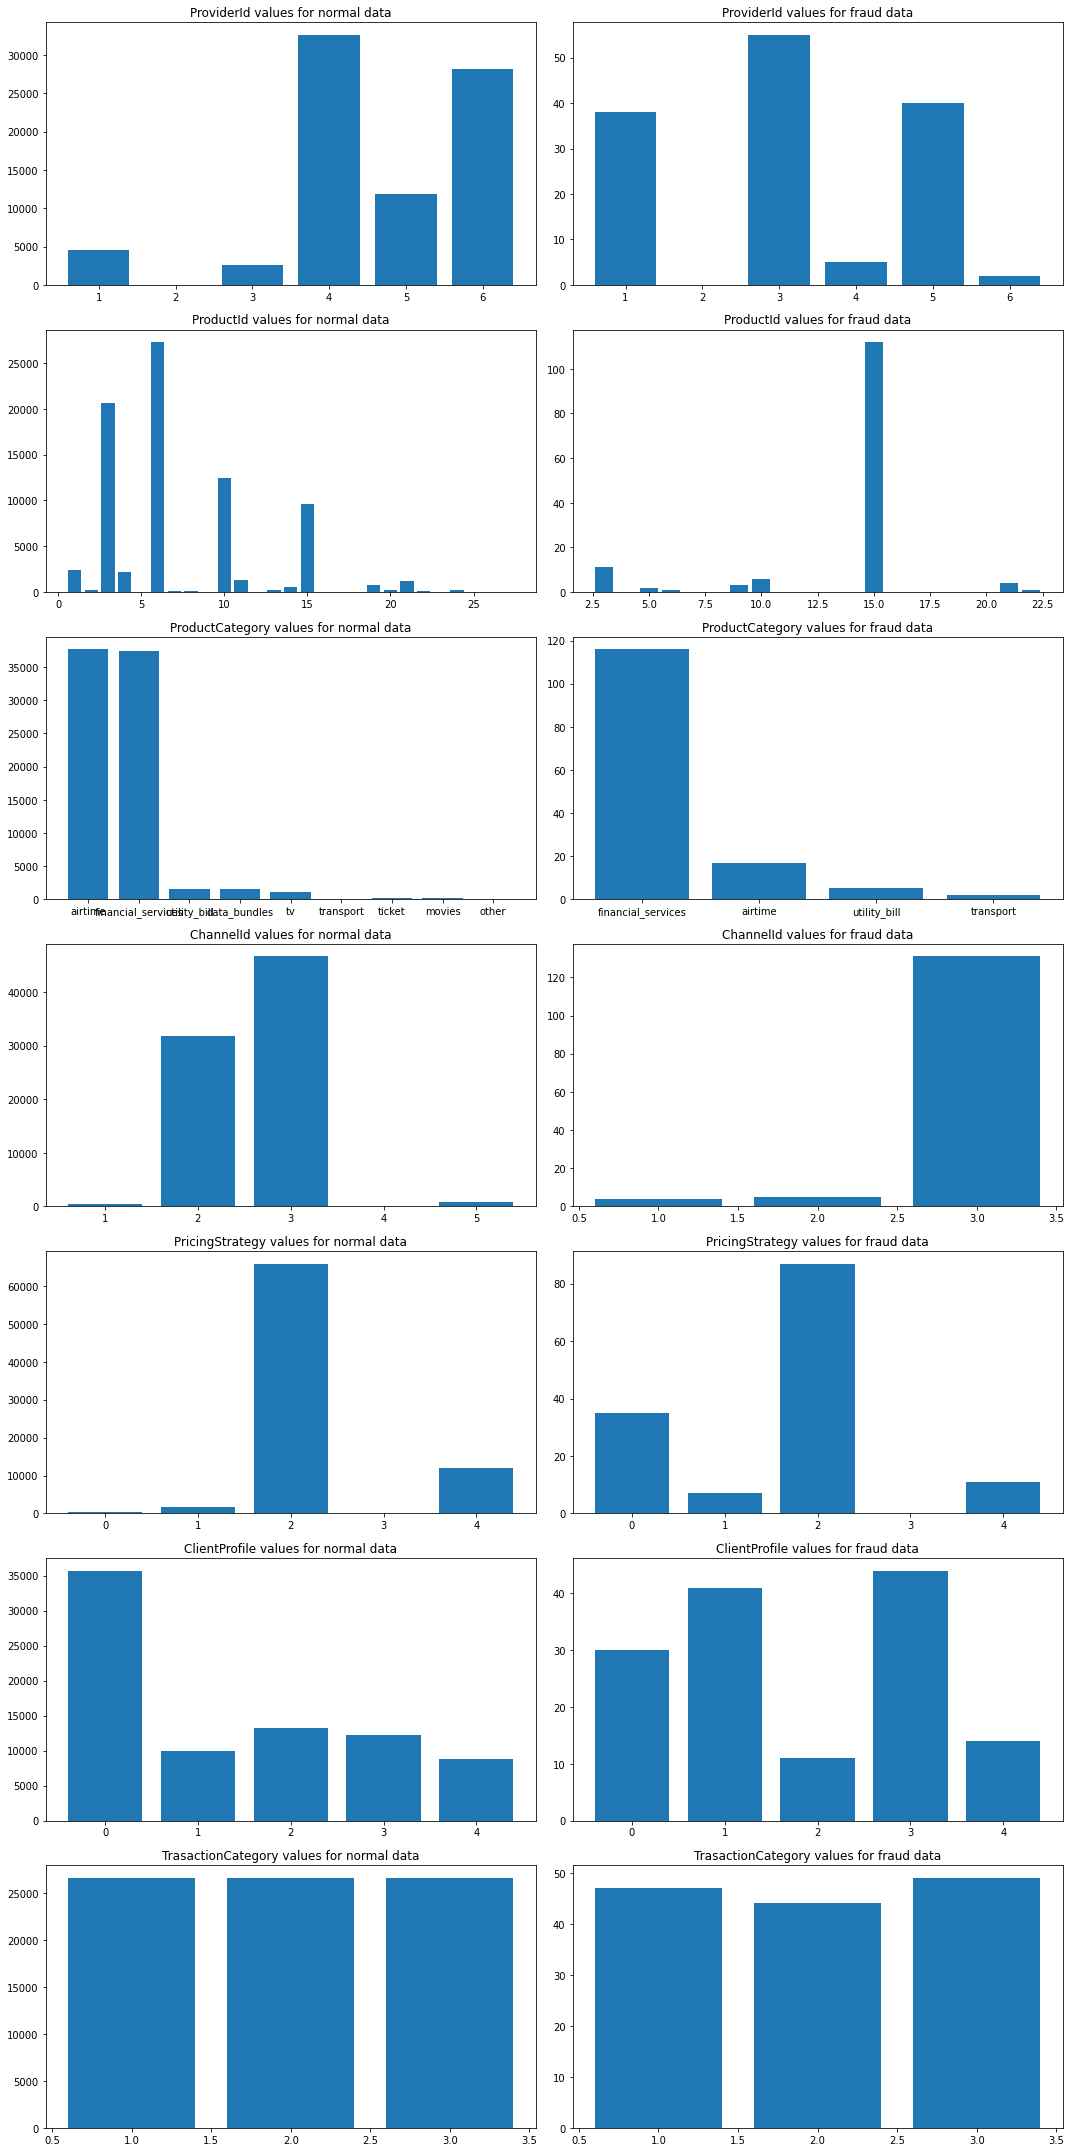

In [8]:
fraud = train[(train['FraudResult'] == 1)]
normal = train[(train['FraudResult'] == 0)]
cols = [x for x in train.columns if x != 'FraudResult' and train[x].nunique() <= 100]
fig, ax = plt.subplots(nrows=len(cols), ncols=2, figsize=(15, 30))
for idx, col in enumerate(cols):
    fraud_col = Counter(fraud[col])
    normal_col = Counter(normal[col])
    ax[idx, 0].bar(normal_col.keys(), normal_col.values())
    ax[idx, 0].set_title(f'{col} values for normal data')
    ax[idx, 1].bar(fraud_col.keys(), fraud_col.values())
    ax[idx, 1].set_title(f'{col} values for fraud data')
    
plt.tight_layout()

Интересно, что пока что не наблюдается очевидных зависимостей между каким-либо признаком и целевой переменной. Однако один из столбцов - "TrasactionCategory" имеет в целом равное распределение значений для обоих классов. Поэтому этот признак также можно смело удалить.

In [9]:
train.drop(columns=['TrasactionCategory'], inplace=True)

Признак "TransactionStartTime" необходимо преобразовать из цельной строки даты и времени в какие-либо значимые признаки. Метод ниже создаёт новые столбцы признаков, созданные на основе сырых временных данных - год, месяц, порядковый номер дня относительно начала года, порядковый номер дня относительно начала месяца, час, минута, порядковый номер дня относительно начала недели. Столбец исходных временных данных при этом выбрасывается

UPD: был еще булевый признак is_weekday, который идентифицировал будний/выходной ли день. Однако после обучения на графике значимости признаков было замечено, что он не вносит своего вклада в обучение (относительно него не принимаются какие-либо решения). Соответственно этот признак был удалён из расчётов.

In [10]:
def transform_time(data):
    data.TransactionStartTime = list(pd.to_datetime(data['TransactionStartTime'], 
         format = '%Y-%m-%d %H:%M:%S', errors = 'coerce'))
    data['TransactionStartTime_year'] = data['TransactionStartTime'].dt.year
    data['TransactionStartTime_month'] = data['TransactionStartTime'].dt.month
    data['TransactionStartTime_doy'] = data['TransactionStartTime'].dt.day_of_year
    data['TransactionStartTime_day'] = data['TransactionStartTime'].dt.day
    data['TransactionStartTime_hour'] = data['TransactionStartTime'].dt.hour
    data['TransactionStartTime_min'] = data['TransactionStartTime'].dt.minute
    data['TransactionStartTime_dow'] = data['TransactionStartTime'].dt.dayofweek
    data.drop(columns=['TransactionStartTime'], inplace=True)
    return data

Признаки "Amount" и "Value" имеют сильную корреляцию по функции модуля. Таким образом, столбец "Amount" достаточно представить в булевом формате для идентификации наличия или отсутствия знака. Для столбца "Value" при этом стоит выполнить масштабирование, поскольку численные значения этого признака могут принимать слишком большие значения относительно других признаков. Поскольку для суммы транзакции нет однозначного диапазона допустимых значений, наилучшим способом будет прологарифмировать этот признак.

In [11]:
def transform_cost(data):
    data.Amount = data.Amount.apply(lambda x: x > 0)
    data.Value = (data.Value).transform(np.log)
    return data

In [12]:
train = transform_time(train)
train = transform_cost(train)

Проверим теперь уникальность значений для каждого признака. Спойлер - стало очевидно лучше, признаки теперь более информативны.

In [13]:
train.nunique()

AccountId                     3219
SubscriptionId                3215
CustomerId                    3311
ProviderId                       6
ProductId                       23
ProductCategory                  9
ChannelId                        4
Amount                           2
Value                         1300
PricingStrategy                  4
FraudResult                      2
ClientProfile                    5
TransactionStartTime_year        2
TransactionStartTime_month       3
TransactionStartTime_doy        78
TransactionStartTime_day        31
TransactionStartTime_hour       24
TransactionStartTime_min        60
TransactionStartTime_dow         7
dtype: int64

In [14]:
train

,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,ClientProfile,TransactionStartTime_year,TransactionStartTime_month,TransactionStartTime_doy,TransactionStartTime_day,TransactionStartTime_hour,TransactionStartTime_min,TransactionStartTime_dow
0,3957,887,4406,6,10,airtime,3,True,6.907755,2,0,4,2018,11,319,15,2,18,3
1,4841,3829,4406,4,6,financial_services,2,False,2.995732,2,0,0,2018,11,319,15,2,19,3
2,4229,222,4683,6,1,airtime,3,True,6.214608,2,0,3,2018,11,319,15,2,44,3
3,648,2185,988,1,21,utility_bill,3,True,9.989665,2,0,3,2018,11,319,15,3,32,3
4,4841,3829,988,4,6,financial_services,2,False,6.467699,2,0,0,2018,11,319,15,3,34,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79885,4841,3829,3795,4,6,financial_services,2,False,8.517193,2,0,0,2019,1,31,31,23,8,3
79886,2577,3326,2994,5,1,airtime,3,True,6.907755,4,0,3,2019,1,31,31,23,44,3
79887,4841,3829,2994,4,6,financial_services,2,False,3.912023,2,0,0,2019,1,31,31,23,45,3
79888,2669,2002,3088,5,15,financial_services,3,True,10.714418,2,0,2,2019,1,31,31,23,51,3


Столбец "ChannelId" выбрасывается относительно результатов промежутчного обучения. На графике значимости признаков он также вносил нулевой вклад в принятие решений.

In [15]:
train.drop(columns=['ChannelId'], inplace=True)

Теперь необходимо сделать кодирование признаков. Столбцы из списка large_cats имеют непоследовательные либо крупные значения. Кодирование здесь используется, чтобы уменьшить величины этих признаков (т.к. они являются однозначно категориальными). Категориальные же признаки с четким диапазоном значений ("ProductCategory" имеет фиксированное количество возможных значений) кодируются как самостоятельные столбцы идентификации принадлежности к той или иной группе/категории (One Hot Enconding). 

In [16]:
large_cats = ['AccountId', 'SubscriptionId','CustomerId', 'ProductId']
for cat in large_cats:
    lb = LabelEncoder()
    train[cat] = lb.fit_transform(list(str(x) for x in train[cat]))

train = pd.get_dummies(train, drop_first=True)

In [17]:
train

,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,Amount,Value,PricingStrategy,FraudResult,ClientProfile,...,TransactionStartTime_min,TransactionStartTime_dow,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
0,2200,3135,2281,6,1,True,6.907755,2,0,4,...,18,3,0,0,0,0,0,0,0,0
1,2852,2103,2281,4,19,False,2.995732,2,0,0,...,19,3,0,1,0,0,0,0,0,0
2,2403,886,2484,6,0,True,6.214608,2,0,3,...,44,3,0,0,0,0,0,0,0,0
3,2968,865,3304,1,11,True,9.989665,2,0,3,...,32,3,0,0,0,0,0,0,0,1
4,2852,2103,3304,4,19,False,6.467699,2,0,0,...,34,3,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79885,2852,2103,1851,4,19,False,8.517193,2,0,0,...,8,3,0,1,0,0,0,0,0,0
79886,1157,1717,1271,5,0,True,6.907755,4,0,3,...,44,3,0,0,0,0,0,0,0,0
79887,2852,2103,1271,4,19,False,3.912023,2,0,0,...,45,3,0,1,0,0,0,0,0,0
79888,1223,731,1333,5,6,True,10.714418,2,0,2,...,51,3,0,1,0,0,0,0,0,0


После необходимых преобразований данные необходимо разделить на набор признаков и целевые переменные

In [18]:
def get_data_and_label(data):
    X = data.drop(columns=['FraudResult'])
    y = data.FraudResult
    return X, y

In [19]:
X, y = get_data_and_label(train)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

Не забываем про дисбаланс классов. Для балансировки здесь используется алгоритм SMOTE - для класса с меньшим количеством экземпляров выбираются произвольные точки и значения для них рассчитываются на основе нескольких ближайших соседей из оригинального набора данных. Такими синтетическими значениями и компенсируется дисбаланс.

In [24]:
smote = SMOTE(random_state=40)
x_train, y_train = smote.fit_resample(x_train, y_train)

In [25]:
x_train

,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,Amount,Value,PricingStrategy,ClientProfile,TransactionStartTime_year,...,TransactionStartTime_min,TransactionStartTime_dow,ProductCategory_data_bundles,ProductCategory_financial_services,ProductCategory_movies,ProductCategory_other,ProductCategory_ticket,ProductCategory_transport,ProductCategory_tv,ProductCategory_utility_bill
0,2852,2103,828,4,19,False,3.912023,2,0,2018,...,18,3,0,1,0,0,0,0,0,0
1,2852,2103,2998,4,19,False,4.605170,2,0,2018,...,39,3,0,1,0,0,0,0,0,0
2,2852,2103,2934,4,19,False,4.094345,2,0,2019,...,28,3,0,1,0,0,0,0,0,0
3,1463,1133,1562,6,16,True,6.907755,2,3,2018,...,28,5,0,0,0,0,0,0,0,0
4,2598,2812,2675,6,16,True,8.006368,2,1,2019,...,50,4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127591,441,1357,629,3,6,True,10.987387,2,0,2019,...,1,3,0,1,0,0,0,0,0,0
127592,441,1357,629,3,6,True,11.512925,2,0,2019,...,4,3,0,1,0,0,0,0,0,0
127593,2543,2253,2618,3,6,True,13.225696,1,3,2018,...,54,0,0,1,0,0,0,0,0,0
127594,2919,1418,3260,5,6,True,13.930744,2,1,2019,...,40,2,0,1,0,0,0,0,0,0


Для обучения используем модель экстремального градиентного бустинга. Алгоритмом жадного перебора можно найти наилучшие гиперпараметры модели для нашей задачи.

In [ ]:
xg_clf = xgb.XGBClassifier()
parameters = {
     "n_estimators": [50, 100, 150, 200, 300],
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(xg_clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(x_train, y_train)

In [246]:
grid.best_params_

{'colsample_bytree': 0.4,
 'eta': 0.3,
 'gamma': 0.3,
 'max_depth': 4,
 'min_child_weight': 1}

In [26]:
xgb_model = xgb.XGBClassifier(
            n_estimators=150,
            colsample_bytree=0.4,
            eta=0.3,
            gamma=0.3,
            max_depth=4,
            objective='multi:softprob',
            use_label_encoder=False,
            num_class=len(set(y_train))) 

In [27]:
xgb_model.fit(x_train, y_train)

[18:13:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eta=0.3, gamma=0.3,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=4, num_class=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [ ]:
f1_scores = cross_val_score(xgb_model, x_train, y_train, cv=5, scoring='f1_micro')
recall_scores = cross_val_score(xgb_model, x_train, y_train, cv=5, scoring='recall_micro')
precision_scores = cross_val_score(xgb_model, x_train, y_train, cv=5, scoring='precision_micro')
print(f1_scores)
print(recall_scores)
print(precision_scores)

Оценим качество обученной модели на тестовой выборке. Одна из важнейших метрик для данной задачи - полнота (recall), так как всё-таки важнее не допустить ошибку второго рода - ошибочно отклонить гипотезу о том, что данная транзакция является мошеннической. При этом ошибочно принимать данную гипотезу для легитимной транзакции (ошибка первого рода) также не стоит слишком часто. Для этого также важно оценивать метрику точности (precision). Обобщённая метрика двух вышеупомянутых - F1 - учитывет оба этих параметра качества.

In [28]:
y_pred = xgb_model.predict(x_test)
print("precision_all:", precision_score(y_test, y_pred, average=None))
print("recall_all:", recall_score(y_test, y_pred, average=None))
print("___________________________________________")
print("accuracy:", accuracy_score(y_test, y_pred))
print("___________________________________________")
print("log loss:", log_loss(y_test, xgb_model.predict_proba(x_test)))
print("___________________________________________")
print("f1_all:", f1_score(y_test, y_pred, average=None))

precision_all: [0.99993731 0.92592593]
recall_all: [0.99987462 0.96153846]
___________________________________________
accuracy: 0.9998122418325197
___________________________________________
log loss: 0.0008122336803662948
___________________________________________
f1_all: [0.99990596 0.94339623]


Оценим значимость признаков при обучении. Наименьший вклад вносят столбцы закодированного категориального признака "ProductCategory", однако удалить лишь некоторые из них мы не можем, т.к. в целом эти столбцы представляют один и тот же признак.

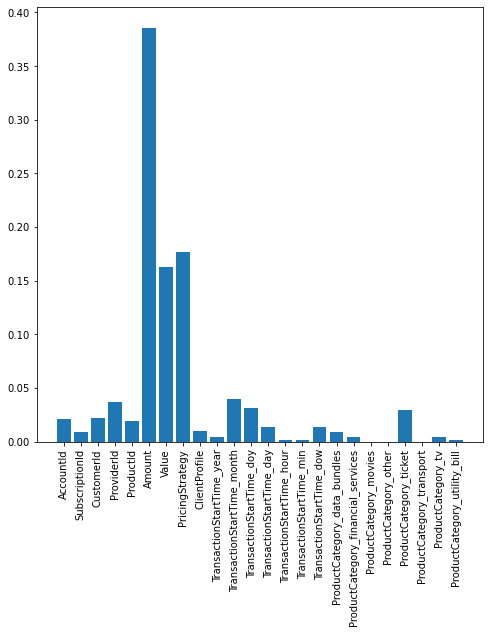

In [35]:
importances = xgb_model.feature_importances_
plt.bar(x_train.columns, importances)
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"] = (8,8)
plt.show()

-------------------------------------------------------------------------------------------------------

Теперь совершим все те же преобразования над тестовыми данными и сохраним результат предсказания модели.

In [29]:
test = pd.read_csv('data/test.csv')

In [30]:
test_ids = test['TransactionId']

In [31]:
cols_to_drop = ['ChannelId', 'CurrencyCode', 'TransactionId', 'BatchId', 'CountryCode', 'TrasactionCategory', 'ChannelId']
test.drop(columns=cols_to_drop, inplace=True)
test = transform_time(test)
test = transform_cost(test)

In [32]:
for cat in large_cats:
    lb = LabelEncoder()
    test[cat] = lb.fit_transform(list(str(x) for x in test[cat]))
test = pd.get_dummies(test, drop_first=True)

In [33]:
test = test.reindex(columns = xgb_model.get_booster().feature_names, fill_value=0)

In [34]:
final_result = xgb_model.predict(test)

In [35]:
Counter(final_result)

Counter({0: 15714, 1: 58})

In [37]:
answers = pd.DataFrame(data={'TransactionId':test_ids, 'FraudResult':final_result})

In [38]:
answers.to_csv('XGB_prediction.csv', index=False)